<a href="https://colab.research.google.com/github/WolfPitToad/SpriteGANPokemonGenerator/blob/main/SpritePokeGAN_V_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
import torch

In [ ]:
#Obtener y mover datos a cuda/gpu
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

In [ ]:
#Mover Dataloader a cuda/gpu
class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dataloader, device):
        self.dataloader = dataloader
        self.device = device
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dataloader: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dataloader)

In [ ]:
device = get_default_device()
print(device)

cuda


In [ ]:
#Instalamos Kaggle para exportar las bases de datos
!pip install -q kaggle

In [ ]:
!rm -rf ~/.kaggle

In [ ]:
#Similar a github, Kaggle nos pide una llave para ingresar esta se descarga en un ARCHIVO llamado kaggle.json
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"w0lfpitt0ad","key":"d012a6f621254bab49bcc53c4e63b5ad"}'}

In [ ]:
#Creamos una nueva carpeta 
!mkdir ~/.kaggle 

In [ ]:
#Copiamos la llave y la ocultamos para evitar sea visible
!cp kaggle.json ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
#Generamos carpetas en Drive para guardar resultados
project_name = "PokemonGANV5-0002"

NEW_DRIVE_FOLDER="/content/drive/MyDrive"
DATASET_ROOT = "/content/drive/MyDrive/Pokemon/pokemon_images"
CHECKPOINT_ROOT = f"/content/drive/MyDrive/Pokemon/checkpoints/{project_name}"
TEST_RESULTS_ROOT = f"/content/drive/MyDrive/Pokemon/test_results/{project_name}"
GEN_RESULTS_ROOT = f"/content/drive/MyDrive/Pokemon/gen_results/{project_name}"

import os
os.makedirs(NEW_DRIVE_FOLDER, exist_ok=True)
os.makedirs(DATASET_ROOT, exist_ok=True)
os.makedirs(CHECKPOINT_ROOT, exist_ok=True)
os.makedirs(TEST_RESULTS_ROOT, exist_ok=True)
os.makedirs(GEN_RESULTS_ROOT, exist_ok=True)

In [ ]:
#Copiamos el codigo AVI del dataset para descargarlo en drive
%cd /content/drive/MyDrive/Pokemon/pokemon_images
! kaggle datasets download -d yehongjiang/pokemon-sprites-images

/content/drive/MyDrive/Pokemon/pokemon_images
  0% 0.00/19.7M [00:00<?, ?B/s]
100% 19.7M/19.7M [00:00<00:00, 261MB/s]


In [ ]:
#Descomprimimos el archivo .zip drive no recomendado t>10 min
!unzip  /content/drive/MyDrive/Pokemon/pokemon_images/pokemon-sprites-images.zip

unzip:  cannot find or open /content/, /content/.zip or /content/.ZIP.


In [ ]:
#Recomendado <10 seg
%cd /content
! kaggle datasets download -d yehongjiang/pokemon-sprites-images
!unzip  /content/drive/MyDrive/Pokemon/pokemon_images/pokemon-sprites-images.zip

Se truncaron las últimas líneas 5000 del resultado de transmisión.
  inflating: pokemon_images/sprites/0374-Nincada-290/front/normal/290-gen3_e.png  
  inflating: pokemon_images/sprites/0374-Nincada-290/front/normal/290-gen4_dp-frame2.png  
  inflating: pokemon_images/sprites/0374-Nincada-290/front/normal/290-gen4_dp.png  
  inflating: pokemon_images/sprites/0374-Nincada-290/front/normal/290-gen4_hs-frame2.png  
  inflating: pokemon_images/sprites/0374-Nincada-290/front/normal/290-gen4_hs.png  
  inflating: pokemon_images/sprites/0374-Nincada-290/front/normal/290-gen5.png  
  inflating: pokemon_images/sprites/0374-Nincada-290/front/shiny/290-gen3_e-frame2.png  
  inflating: pokemon_images/sprites/0374-Nincada-290/front/shiny/290-gen3_e.png  
  inflating: pokemon_images/sprites/0374-Nincada-290/front/shiny/290-gen4_dp-frame2.png  
  inflating: pokemon_images/sprites/0374-Nincada-290/front/shiny/290-gen4_dp.png  
  inflating: pokemon_images/sprites/0374-Nincada-290/front/shiny/290-gen4_h

In [ ]:
import os
import random
import datetime
import io

import numpy as np
import pandas as pd
from sklearn.preprocessing import MultiLabelBinarizer
from PIL import Image
import matplotlib.pyplot as plt
plt.ioff()
%matplotlib inline
from IPython.display import HTML

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.utils.parametrizations import spectral_norm
from torch.utils.data import Dataset, DataLoader
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
from torch.autograd import Variable, grad
from torchsummary import summary
from torch.utils.tensorboard import SummaryWriter
%load_ext tensorboard

In [ ]:
#Desde Drive (No recomendado tiempo >10min)
NEW_DATA_ROUTE= '/content/drive/MyDrive/Pokemon/pokemon_images/pokemon_images'

In [ ]:
#Recomendado, tiempo de ejecución 3seg
NEW_DATA_ROUTE= '/content/pokemon_images'

In [ ]:
 #Adaptado de https://github.com/rubyyhj/PokeTypeGAN/blob/main/PokeTypeGAN.ipynb
 class PokemonSpritesDataset(Dataset):
    def __init__(self, root_dir):
      ##Rutas del sprite
      self.root_dir= root_dir
      self.sprites_dir = os.path.join(self.root_dir, "sprites")
      self.pokedex_df = pd.read_csv(os.path.join(root_dir, "pokedex.csv"))
      ## Adaptar el sprite
      self.transform = transforms.Compose([
          transforms.RandomHorizontalFlip(p=0.5),
          transforms.ToTensor(),
          transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
          transforms.Resize(64) #Generamos imagen de 64x64
        ])
      ## Obtener el sprite
      self.images = []
      self.pkmn = []
  
      for entry in os.scandir(self.sprites_dir):
          if not entry.is_dir():
              continue
         
          pokedex_id = int(entry.name[:4])
          pokemon = self.pokedex_df.iloc[pokedex_id]["name"]
          image_dirs = [
              os.path.join(entry.path, "front", "normal")
          ]
          for image_dir in image_dirs:
                is_front = "/front/" in image_dir                
                
                for fn in os.listdir(image_dir):
                    if not fn.endswith(".png"):
                        continue
                    
                    image = Image.open(os.path.join(image_dir, fn))
                    self.images.append(self.transform(image))
                    self.pkmn.append(pokemon)
      self.images = torch.from_numpy(np.stack(self.images))   
    def __len__(self):
        return self.images.shape[0] #Importante para el ploteo
    def __getitem__(self, idx):
        return self.images[idx], self.pkmn[idx] #Importante para el dataloader


In [ ]:
def matplotlib_to_PIL(fig):
    """Convert a Matplotlib figure to a PIL Image and return it"""
    buffer = io.BytesIO()
    fig.savefig(buffer, bbox_inches='tight')
    buffer.seek(0)
    image = Image.open(buffer)
    return image

In [ ]:
    #Generar cuadricula
def make_images_grid(images,pkmn, row=8, col=8):
        
        fig, axs = plt.subplots(row, col, figsize=(row * 3, col * 2))
        for i in range(row):
            for j in range(col):
                idx = i * col + j
                axs[i][j].axis('off')
                axs[i][j].imshow(np.transpose(images[idx] * 0.5 + 0.5, (1, 2, 0)))
                axs[i][j].set_title(str(pkmn[idx]), fontsize=12)

        image = matplotlib_to_PIL(fig)
        plt.close(fig)
        return image       

In [ ]:
dataset=PokemonSpritesDataset(NEW_DATA_ROUTE)
torch.cuda.empty_cache()

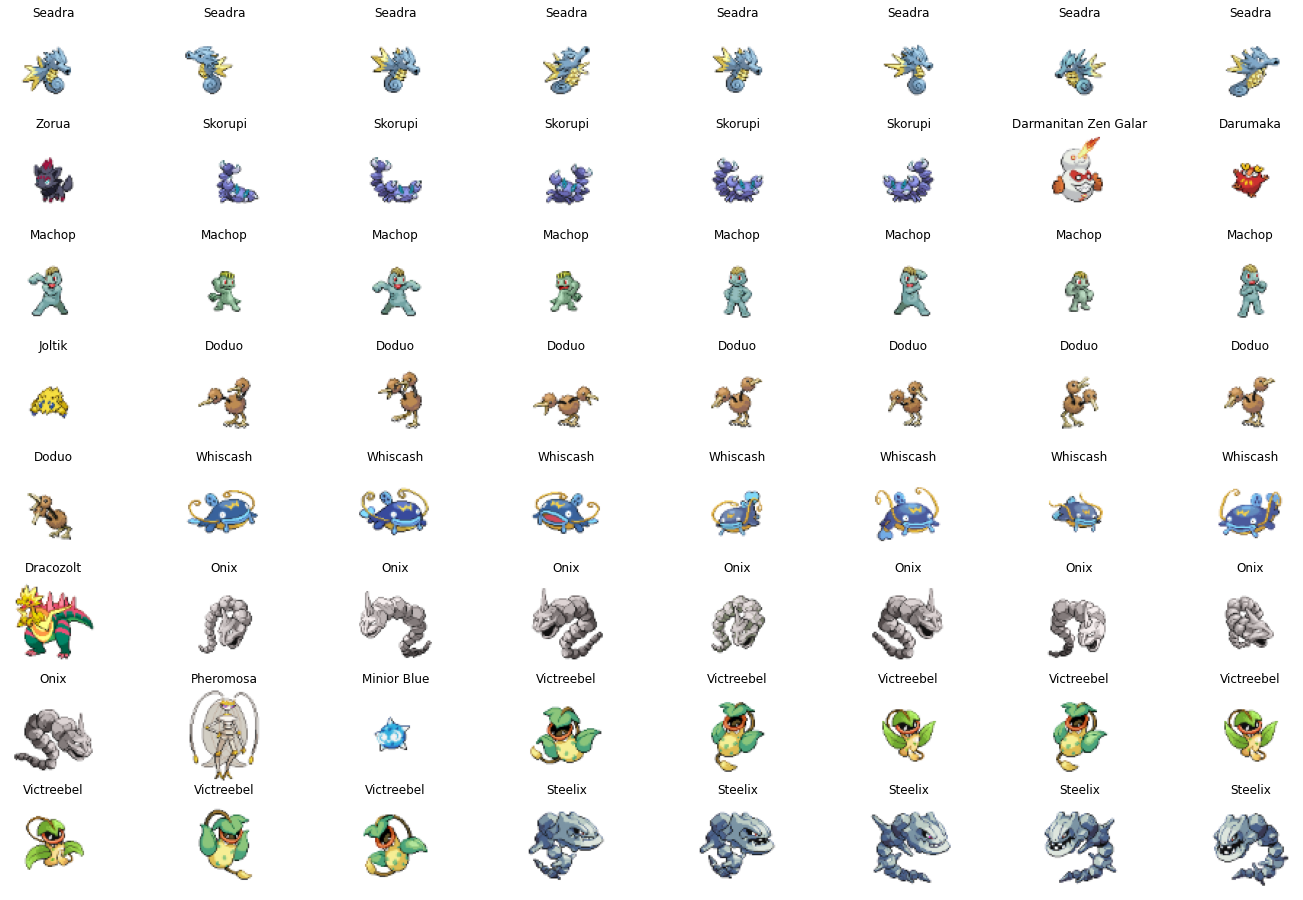

In [ ]:
make_images_grid(dataset.images,dataset.pkmn)

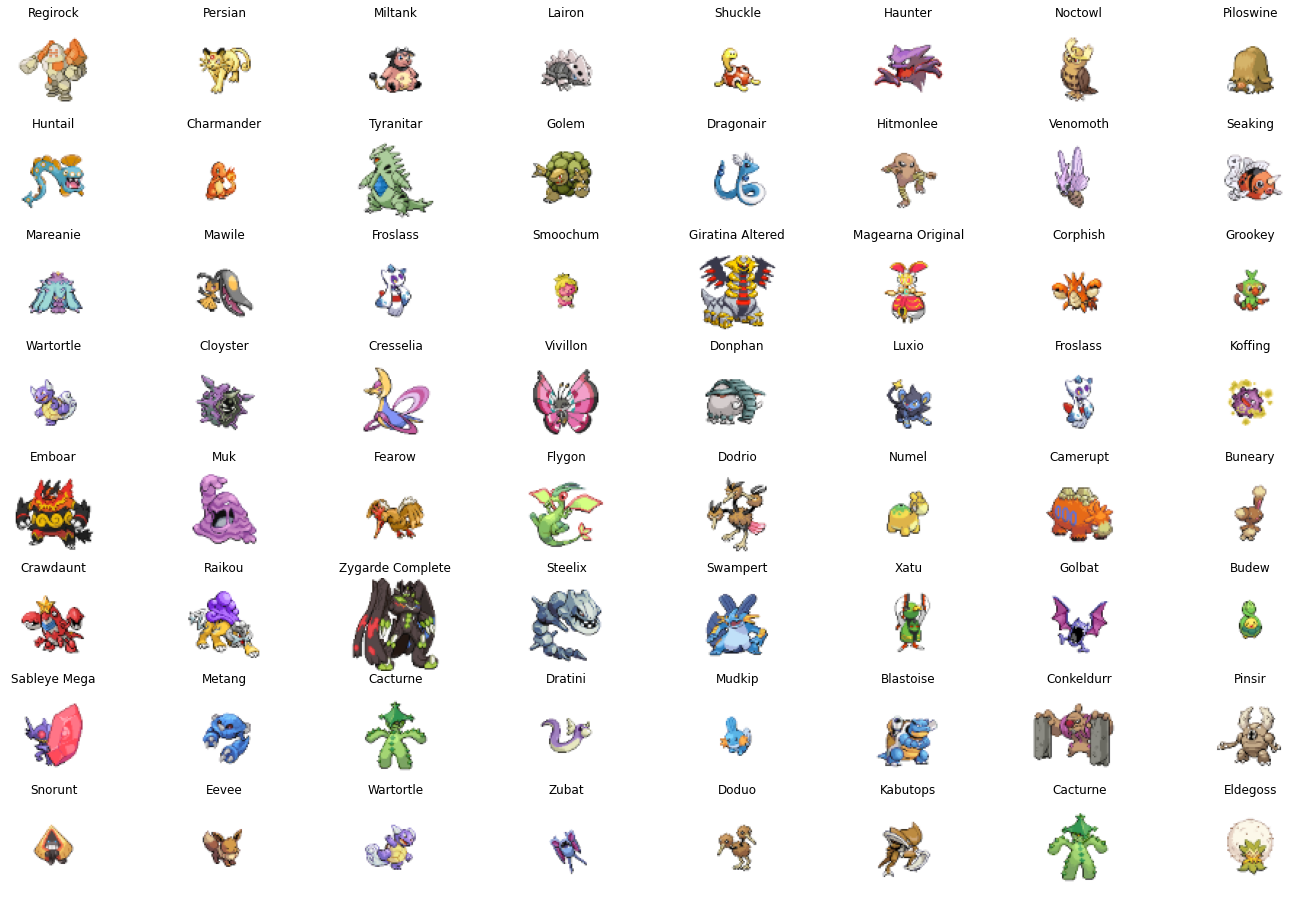

In [ ]:
dataloader_example = DataLoader(dataset, batch_size=64, shuffle=True,num_workers=4, pin_memory=False )
example_images, example_labels = next(iter(dataloader_example))
make_images_grid(example_images, example_labels)


In [ ]:
#Generar modelo Generador de Pokemon Falsos

class Generator(nn.Module):
   def __init__ (self,seed_size):
     super(Generator, self).__init__()
     self.main=nn.Sequential(
     #Input seed_size x 1 x 1
     nn.ConvTranspose2d(seed_size, 32, kernel_size=4, padding=0, stride=1, bias=False),
     nn.BatchNorm2d(32),
     nn.ReLU(True),

     nn.ConvTranspose2d(32, 64, kernel_size=4, padding=1, stride=2, bias=False),
     nn.BatchNorm2d(64),
     nn.ReLU(True),

     nn.ConvTranspose2d(64, 128, kernel_size=4, padding=1, stride=2, bias=False),
     nn.BatchNorm2d(128),
     nn.ReLU(True),

     nn.ConvTranspose2d(128, 64, kernel_size=4, padding=1, stride=2, bias=False),
     nn.BatchNorm2d(64),
     nn.ReLU(True),

     nn.ConvTranspose2d(64, 3, kernel_size=4, padding=1, stride=2, bias=False),
     nn.Tanh()
     )

   def forward(self, input):
        return self.main(input)
      # Output: 3 x 64 x 64

In [ ]:
seed_size=20
batch_size=64
generator=Generator(seed_size)
seed_batch = torch.randn(batch_size, seed_size, 1, 1)
fake_pokemon=generator(seed_batch)
row=2
col=2

In [ ]:
#Visualizar data
fake_pokemon_np=fake_pokemon.detach().numpy()
fr=fake_pokemon_np.reshape(64,64,3,batch_size)

In [ ]:
fake_pokemon.detach().size()

torch.Size([64, 3, 64, 64])

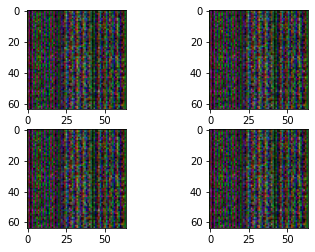

In [ ]:
fig, axs = plt.subplots(row,col,figsize=(row * 3, col * 2))
for n in range(batch_size):
    for i in range(row):
            for j in range(col):
              #Ver imagenes en rgb eliminar 1 y colocar :
              axs[i][j].imshow(fr[:, :, :, n])


In [ ]:
#Generar modelo Discriminador
class Discriminator(nn.Module):
  def __init__(self):
    super(Discriminator,self). __init__()
    self.dis= nn.Sequential(
        #3 x 64 x 64
        nn.Conv2d(3, 256, kernel_size= 4,stride= 2,padding= 1, bias=False),
        nn.BatchNorm2d(256),
        nn.LeakyReLU(0.2,inplace=True),
        #64 x 32 x 32
        nn.Conv2d(256, 256, kernel_size= 4,stride=2,padding=1, bias=False),
        nn.BatchNorm2d(256),
        nn.LeakyReLU(0.2,inplace=True),
        #128x16x16
        nn.Conv2d(256, 128, kernel_size= 4,stride=2,padding=1, bias=False),
        nn.BatchNorm2d(128),
        nn.LeakyReLU(0.2,inplace=True),
        #128x8x8
        nn.Conv2d(128,128, kernel_size= 4,stride=2,padding=1, bias=False),
        nn.BatchNorm2d(128),
        nn.LeakyReLU(0.2,inplace=True),

        nn.Conv2d(128, 1,kernel_size= 4, stride= 1, padding= 0, bias=False),
        nn.Sigmoid()
        )
  def forward(self, input):
        return self.dis(input)

In [ ]:
discriminator=Discriminator()
learning_rate=0.000275
beta1=0.5
optimizerD = optim.Adam(discriminator.parameters(), lr=learning_rate, betas=(beta1, 0.9))

print(discriminator.children)

<bound method Module.children of Discriminator(
  (dis): Sequential(
    (0): Conv2d(3, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
    (3): Conv2d(256, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.2, inplace=True)
    (6): Conv2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): LeakyReLU(negative_slope=0.2, inplace=True)
    (9): Conv2d(128, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): LeakyReLU(negative_slope=0.2, inplace=True)
   

In [ ]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [ ]:
discriminator.apply(weights_init)
print(discriminator)

Discriminator(
  (dis): Sequential(
    (0): Conv2d(3, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
    (3): Conv2d(256, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.2, inplace=True)
    (6): Conv2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): LeakyReLU(negative_slope=0.2, inplace=True)
    (9): Conv2d(128, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): LeakyReLU(negative_slope=0.2, inplace=True)
    (12): Conv2d(128, 1, kernel_size

In [ ]:
#Parte Falsa
decision=discriminator(fake_pokemon)
print(decision)

tensor([[[[0.4872]]],


        [[[0.5961]]],


        [[[0.4638]]],


        [[[0.5911]]],


        [[[0.3505]]],


        [[[0.2985]]],


        [[[0.6898]]],


        [[[0.4675]]],


        [[[0.6723]]],


        [[[0.5807]]],


        [[[0.7249]]],


        [[[0.6742]]],


        [[[0.4104]]],


        [[[0.6492]]],


        [[[0.6005]]],


        [[[0.6841]]],


        [[[0.5012]]],


        [[[0.5646]]],


        [[[0.5122]]],


        [[[0.5272]]],


        [[[0.7966]]],


        [[[0.4807]]],


        [[[0.6780]]],


        [[[0.3765]]],


        [[[0.7561]]],


        [[[0.6442]]],


        [[[0.6120]]],


        [[[0.4767]]],


        [[[0.6726]]],


        [[[0.6683]]],


        [[[0.8045]]],


        [[[0.5273]]],


        [[[0.5004]]],


        [[[0.5615]]],


        [[[0.6410]]],


        [[[0.5436]]],


        [[[0.6542]]],


        [[[0.4917]]],


        [[[0.6107]]],


        [[[0.6707]]],


        [[[0.6077]]],


        [[[0.460

In [ ]:
#Parte Real
decision=discriminator(example_images)
print(decision)

tensor([[[[0.5231]]],


        [[[0.2277]]],


        [[[0.5479]]],


        [[[0.7282]]],


        [[[0.6482]]],


        [[[0.5834]]],


        [[[0.1554]]],


        [[[0.6220]]],


        [[[0.7243]]],


        [[[0.3546]]],


        [[[0.5908]]],


        [[[0.4776]]],


        [[[0.1845]]],


        [[[0.5894]]],


        [[[0.4721]]],


        [[[0.5740]]],


        [[[0.6329]]],


        [[[0.3627]]],


        [[[0.7435]]],


        [[[0.7313]]],


        [[[0.6421]]],


        [[[0.7087]]],


        [[[0.7103]]],


        [[[0.6156]]],


        [[[0.5676]]],


        [[[0.6371]]],


        [[[0.6558]]],


        [[[0.4444]]],


        [[[0.3427]]],


        [[[0.4891]]],


        [[[0.5927]]],


        [[[0.5564]]],


        [[[0.7123]]],


        [[[0.6204]]],


        [[[0.6604]]],


        [[[0.5356]]],


        [[[0.5305]]],


        [[[0.6560]]],


        [[[0.6995]]],


        [[[0.1713]]],


        [[[0.3887]]],


        [[[0.535

In [ ]:
from tqdm.notebook import tqdm
import torch.nn.functional as F

In [ ]:
real_label=1
fake_label=0

In [ ]:
def trainNET(data,optimizerD,optimizerG,seed_size,batch_size=64):
   
    #Parte Real
    optimizerD.zero_grad()
    real_cpu = data[0].to(device)
    b_size = real_cpu.size(0)
    #label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
    label = torch.rand(real_cpu.size(0), device=device) * (0.1 - 0) + 0 
    
    real_predictions = discriminator(real_cpu).view(-1)
    real_loss = criterion(real_predictions, label)
    #real_loss.backward(retain_graph=True)
    real_score = real_predictions.mean().item()
    #Parte falsa
    
    latent_batch = torch.randn(b_size, seed_size, 1, 1, device=device)
    fake_pokemon = generator(latent_batch)
    #label.fill_(fake_label)
    label= torch.rand(real_cpu.size(0), device=device) * (1 - 0.9) + 0.9

    gen_predictions = discriminator(fake_pokemon.detach()).view(-1)
    gen_loss= criterion(gen_predictions,label)
    #gen_loss.backward()
    total_loss = real_loss + gen_loss    
    total_loss.backward()
    optimizerD.step()
    #Entrenar Generador
    
    gen_score = torch.mean(gen_predictions).item()
    
    #optimizerD.step()
    optimizerG.zero_grad()
    latent_batch = torch.randn(b_size, seed_size, 1, 1, device=device)
    fake_pokemon = generator(latent_batch)
    #label.fill_(real_label)
    label=torch.zeros(real_cpu.size(0), device=device)
    disc_predictions = discriminator(fake_pokemon).view(-1)
    loss = criterion(disc_predictions, label)
   
    loss.backward()
    #generator_loss = disc_predictions.mean().item()
    optimizerG.step()
    

    return total_loss.item(), real_score, gen_score, loss.item() 

In [ ]:
import torchvision.utils as vutils

In [ ]:
def trainGAN(num_epoch,iters,batch_size=64,seed_size=20,beta1=0.5,learning_rate=0.000275,idx=1,):
  torch.cuda.empty_cache()
   # Track losses and scores
  disc_losses = []
  disc_scores = []
  gen_losses = []
  gen_scores = []
  iters= iters


  print("Entrenando...")
  for epoch in range(num_epoch):  
   for i, data in enumerate(dataloader_example, 0):
     disc_loss, real_score, gen_score,gen_loss =trainNET(data,optimizerD,optimizerG,seed_size,batch_size)
   iters+=1
   disc_losses.append(disc_loss)
   disc_scores.append(real_score)
   gen_losses.append(gen_loss)
   gen_scores.append(gen_score)
   print("Epoch [{}/{}], gen_loss: {:.4f}, disc_loss: {:.4f}, real_score: {:.4f}, gen_score: {:.4f}".format(
            iters, num_epoch, gen_loss, disc_loss, real_score, gen_score))
   if (iters % 10 == 0) or ((epoch == num_epoch/100 == 0)):
    save_model(CHECKPOINT_ROOT, generator, discriminator, iters)
    save_image(TEST_RESULTS_ROOT, generator, iters,(fixed_noise))

   
  return disc_losses, disc_scores, gen_losses, gen_scores

In [ ]:
criterion = nn.BCELoss()
optimizerD = optim.Adam(discriminator.parameters(), lr=learning_rate, betas=(beta1, 0.9))
optimizerG = optim.Adam(generator.parameters(), lr=learning_rate, betas=(beta1, 0.9))

In [ ]:
#Pasamos la semilla del batch a GPU
seed_batch=to_device(seed_batch,device)

In [ ]:
seed_size=20
batch_size=64
fixed_noise = torch.randn(batch_size, seed_size, 1, 1)
fixed_noise=fixed_noise.to(device)

In [ ]:
#Pasamos todo a un mismo entorno
to_device(generator,device)
to_device(discriminator,device)

Discriminator(
  (dis): Sequential(
    (0): Conv2d(3, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
    (3): Conv2d(256, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.2, inplace=True)
    (6): Conv2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): LeakyReLU(negative_slope=0.2, inplace=True)
    (9): Conv2d(128, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): LeakyReLU(negative_slope=0.2, inplace=True)
    (12): Conv2d(128, 1, kernel_size

In [ ]:
def save_model(save_dir, generator, discriminator, iters):
    iters_k = iters // 10
    G_path = os.path.join(save_dir,  f"{iters_k:05d}k-G.pth")
    D_path = os.path.join(save_dir,  f"{iters_k:05d}k-D.pth")

    torch.save(generator.state_dict(), G_path)
    torch.save(discriminator.state_dict(), D_path)

    print("Guardando Generador en ", G_path, "y Discriminador en", D_path)

In [ ]:
def save_image(save_dir, generator, iters, fixed_noise):
    iters_k = iters // 10

    generator.eval()
    with torch.no_grad():
        gen_images = generator(fixed_noise).detach().cpu()
    image = make_images_grid(gen_images,example_labels)

    img_path = os.path.join(save_dir, f"{iters_k:05d}k.png")
    image.save(img_path)
    print("Guardando imagen Generada en...", img_path)

In [ ]:
#Cargar GAN y correr con checkpoints no se recomienda >250 epocas de entrenamiento acumuladas, colapsa la generación de imagenes
#apartir de las 50-100 epocas
trainGAN(100,1)

Entrenando...
Epoch [202/100], gen_loss: 2.8282, disc_loss: 0.4387, real_score: 0.0605, gen_score: 0.9573
Epoch [203/100], gen_loss: 3.8553, disc_loss: 0.4113, real_score: 0.0694, gen_score: 0.9672
Epoch [204/100], gen_loss: 2.7735, disc_loss: 0.4260, real_score: 0.0382, gen_score: 0.9417
Epoch [205/100], gen_loss: 4.0016, disc_loss: 0.4649, real_score: 0.0254, gen_score: 0.8963
Epoch [206/100], gen_loss: 3.5777, disc_loss: 0.3941, real_score: 0.0542, gen_score: 0.9542
Epoch [207/100], gen_loss: 3.0644, disc_loss: 0.3977, real_score: 0.0442, gen_score: 0.9339
Epoch [208/100], gen_loss: 4.0287, disc_loss: 0.4839, real_score: 0.0290, gen_score: 0.8452
Epoch [209/100], gen_loss: 3.5489, disc_loss: 0.4007, real_score: 0.0621, gen_score: 0.9713
Epoch [210/100], gen_loss: 2.8346, disc_loss: 0.4451, real_score: 0.0849, gen_score: 0.9729
Guardando Generador en  /content/drive/MyDrive/Pokemon/checkpoints/PokemonGANV5-0002/00021k-G.pth y Discriminador en /content/drive/MyDrive/Pokemon/checkpoint

KeyboardInterrupt: ignored

In [ ]:
from IPython.display import Image

In [ ]:
with torch.no_grad():
        latent_batch = torch.randn(batch_size, seed_size, 1, 1, device=device)
        gen_images = generator(latent_batch).detach().cpu()
        generated_pokemon = make_images_grid(gen_images,example_labels)

In [ ]:
def load_model(save_dir, generator, discriminator, iters):
    iters_k = iters // 10
    G_path = os.path.join(save_dir,  f"{iters_k:05d}k-G.pth")
    D_path = os.path.join(save_dir,  f"{iters_k:05d}k-D.pth")

    generator.load_state_dict(torch.load(G_path))
    discriminator.load_state_dict(torch.load(D_path))
    
    print("Loaded generator from", G_path, "and discriminator from", D_path)

In [ ]:
load_model(CHECKPOINT_ROOT, generator, discriminator, 100)

Loaded generator from /content/drive/MyDrive/Pokemon/checkpoints/PokemonGANV5-0002/00015k-G.pth and discriminator from /content/drive/MyDrive/Pokemon/checkpoints/PokemonGANV5-0002/00015k-D.pth


Falta Recuperar la imagen una vez procesada por el GPU

In [ ]:
latent_batch = torch.randn(batch_size, seed_size, 1, 1, device=device)
#fake_pokemon = generator(seed_batch)
#fake_pokemon_np=fake_pokemon.cpu().detach().numpy()
#fr=fake_pokemon_np.reshape(64,64,3,batch_size)

Ejemplo tras una epoca de entrenamiento en CPU, se me acabo de vuelta la GPU xD podemos observar como cambio el fondo a pixeles blancos y comienza a generar pixeles de colores por el centro va por buen camino

Bibliografia, les recomiendo checarla porque se utilizó

https://www.kaggle.com/datasets/yehongjiang/pokemon-sprites-images

https://github.com/rubyyhj/PokeTypeGAN/blob/main/PokeTypeGAN.ipynb

https://www.tensorflow.org/tutorials/generative/dcgan

https://github.com/jkleiber/PokeGAN/blob/master/PokeGAN.ipynb
